In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg
import scipy.stats
from scipy.ndimage.filters import gaussian_filter1d,gaussian_filter
from six.moves import urllib
import os
import sklearn.decomposition
from PIL import Image

# before we start install UMAP
# (see documentation here https://github.com/lmcinnes/umap)
# pip install umap-learn

# download image set from UPenn
if not os.path.isfile('image_data/img1.jpg'):
    if not os.path.exists('image_data'):
        os.mkdir('image_data')
    for d in range(66):
        with urllib.request.urlopen('ftp://tofu.psych.upenn.edu/fulldb/cd01A/DSC_%04d.JPG'%(d+1)) as response:
            with open('image_data/img%d.jpg'%d,'wb') as f:
                f.write(response.read())

# download 2-photon data
if not os.path.isfile('data/stimspont.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    with urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/stimspont.npy') as response:
        with open('data/stimspont.npy','wb') as f:
            f.write(response.read())

In [24]:
# extract patches from images and make them grayscale!
nyp = 35
nxp = 35
n0 = 250
imgs = np.zeros((66*n0,nyp,nxp),dtype=np.uint8)    
for d in range(66):
    img=np.array(Image.open('image_data/img%d.jpg'%d))
    img = np.round((img.astype(np.float32)).mean(axis=2)).astype(np.uint8)
    ny,nx = img.shape
    for k in range(n0):
        ry = np.random.randint(ny-nyp)
        rx = np.random.randint(nx-nxp)
        py = np.arange(ry,ry+nyp,dtype=int)
        px = np.arange(rx,rx+nxp,dtype=int)
        imgs[k+d*n0,:,:] = img[np.ix_(py,px)]
        

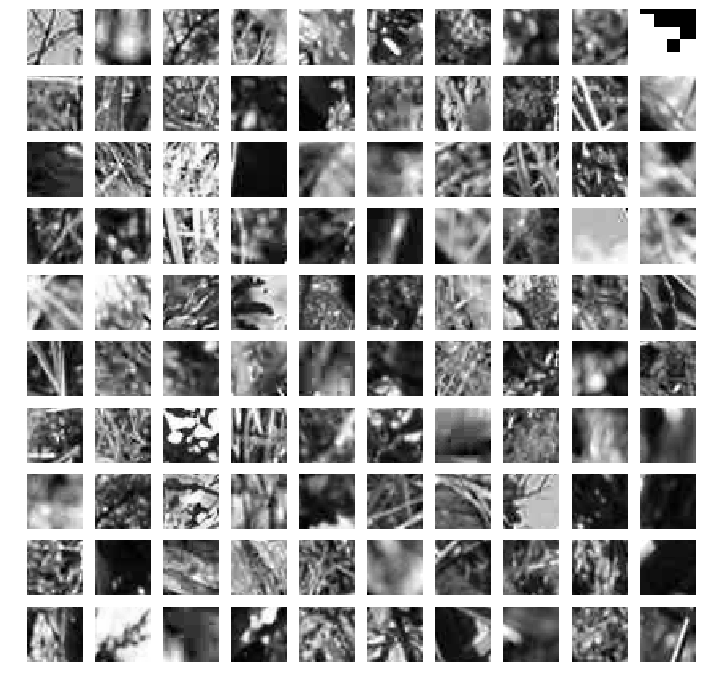

In [25]:
fig=plt.figure(figsize=(12,12))
for n in range(100):
    ax = fig.add_subplot(10,10,n+1)
    ax.imshow(imgs[np.random.randint(imgs.shape[0]),:,:], cmap=plt.get_cmap('gray'))
    ax.axis('off')

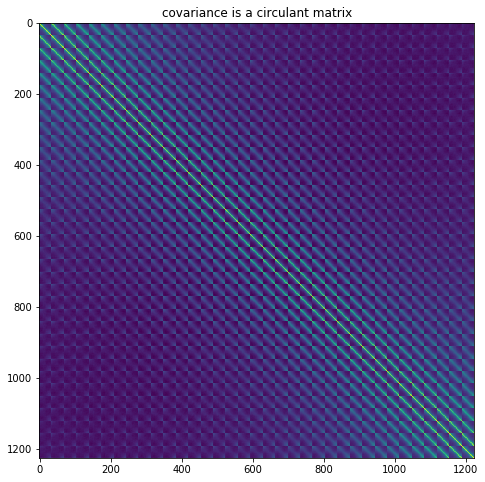

In [29]:
### find the principal components of the image patches

# first flatten the images
imgflat = np.reshape(imgs,(imgs.shape[0],-1))

# remember scipy.sparse.linalg.eigsh? we'll need a covariance matrix for that
# compute covariance of images
imgcov = (imgflat-imgflat.mean(axis=1)[:,np.newaxis]).T @ (imgflat-imgflat.mean(axis=1)[:,np.newaxis])

fig=plt.figure(figsize=(8,8))
plt.imshow(imgcov)
plt.title('covariance is a circulant matrix')
plt.show()

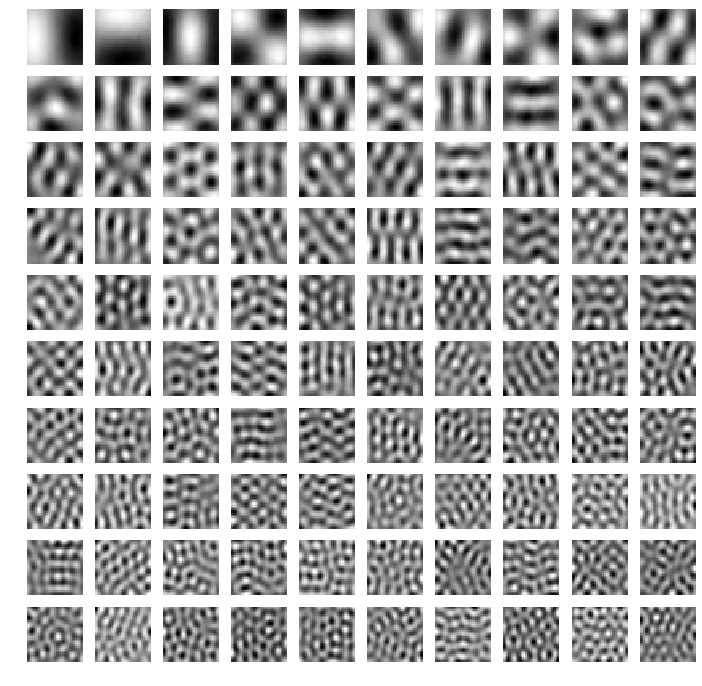

In [9]:
### compute eigenvectors
npcs = 100
sv,u = scipy.sparse.linalg.eigsh(imgcov, k=npcs)
# they're in reverse order (u[:,-1] is top PC)

# visualize the PCs
fig=plt.figure(figsize=(12,12))
for n in range(npcs):
    ax = fig.add_subplot(10,10,n+1)
    ax.imshow(np.reshape(u[:,-(n+1)],(nyp,nxp)), cmap=plt.get_cmap('gray'))
    ax.axis('off')
    #ax.set_title('PC %d'%(n+1))

In [10]:
### find the independent components! (ICA)
model = sklearn.decomposition.FastICA(n_components=100,algorithm='parallel')
# flattened and mean-centered data
#model = model.fit(np.reshape(imgsub,(imgsub.shape[0],-1)))
model = model.fit(imgflat - imgflat.mean(axis=1)[:,np.newaxis])
s = model.components_

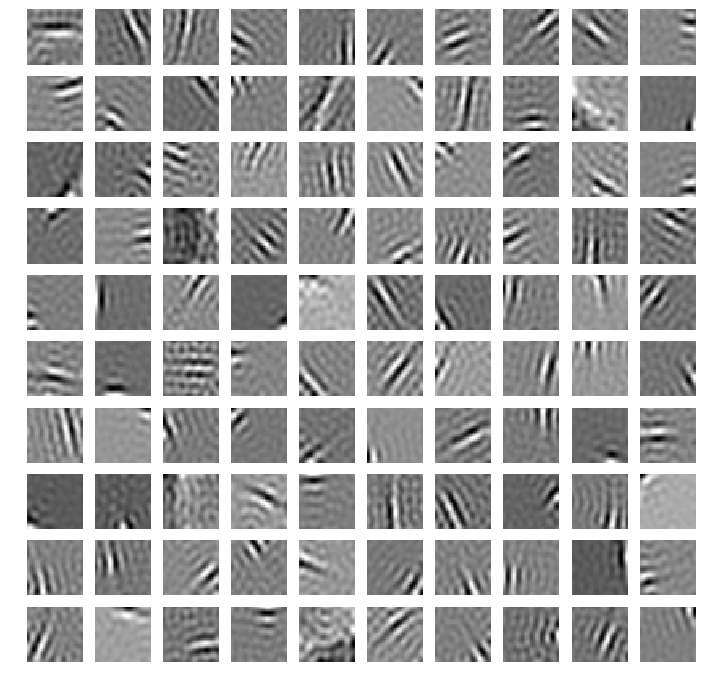

In [11]:
# visualize the ICs
fig=plt.figure(figsize=(12,12))
for n in range(100):
    ax = fig.add_subplot(10,10,n+1)
    ax.imshow(np.reshape(s[n,:],(nyp,nxp)), cmap=plt.get_cmap('gray'))
    ax.axis('off')
    #ax.set_title('IC %d'%(n+1))

In [2]:
# let's try UMAP or TSNE, look up parameters and play with them
# may need to increase number of iterations
from sklearn.manifold import TSNE
import umap

# use smaller image patches (and fewer)
nyp = 15
nxp = 15
n0 = 100
imgs = np.zeros((66*n0,nyp,nxp),dtype=np.uint8)    
for d in range(66):
    img=np.array(Image.open('image_data/img%d.jpg'%d))
    img = np.round((img.astype(np.float32)).mean(axis=2)).astype(np.uint8)
    ny,nx = img.shape
    for k in range(n0):
        ry = np.random.randint(ny-nyp)
        rx = np.random.randint(nx-nxp)
        py = np.arange(ry,ry+nyp,dtype=int)
        px = np.arange(rx,rx+nxp,dtype=int)
        imgs[k+d*n0,:,:] = img[np.ix_(py,px)]
        
imgflat = np.reshape(imgs,(imgs.shape[0],-1)).astype(np.float32)
imgflat -= imgflat.mean(axis=1)[:,np.newaxis]


In [12]:
# run UMAP and/or TSNE
# UMAP
out = umap.UMAP(n_neighbors=40,n_components=2,min_dist=0.05).fit_transform(imgflat)

# TSNE
# out = TSNE(n_components=2,perplexity=50).fit_transform(imgflat)

### if you want you can download and install the multicore version of tsne
# (https://github.com/DmitryUlyanov/Multicore-TSNE)
# from MulticoreTSNE import MulticoreTSNE as TSNE
# tsne = TSNE(n_jobs=8)
# out  = tsne.fit_transform(imgflat)

<IPython.core.display.Javascript object>


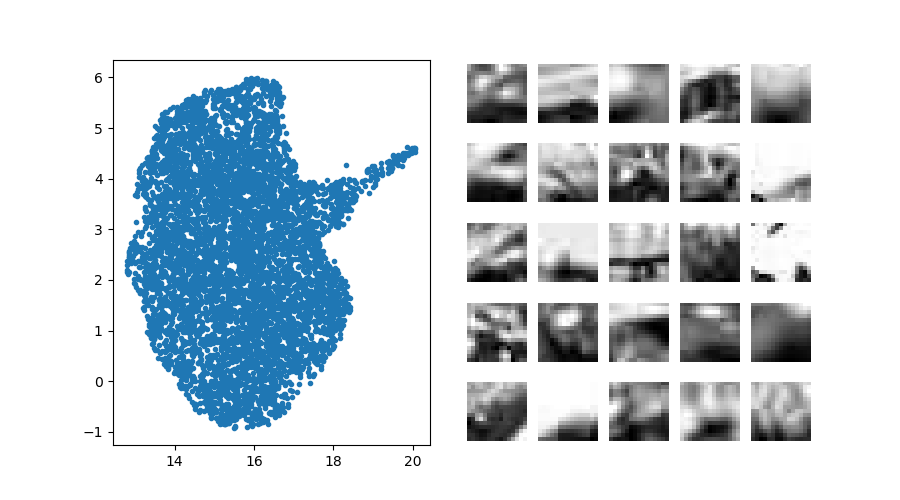

In [13]:
from importlib import reload
reload(plt)
%matplotlib notebook

# create figure and plot scatter

# create the annotations box
#im = OffsetImage(img0[0,:,:])
fig, axes = plt.subplots(5,10, figsize=(9,5))
for ni in range(5):
    for nj in range(10):
        axes[ni,nj].axis('off')

ax = fig.add_subplot(1,2,1)
ax.plot(out[:,0],out[:,1], ls="", marker=".")
    
def onclick(event):
    # if the mouse is over the scatter points
    #if line.contains(event)[0]:
    # find out the index within the array from the event
    dists = (out[:,0]-event.xdata)**2 + (out[:,1]-event.ydata)**2
    inds = dists.argsort()[:25]
    for ni in range(5):
        for nj in range(5):
            axes[ni,nj+5].imshow(imgs[inds[ni+nj*5],:,:],plt.get_cmap('gray'))
            axes[ni,nj+5].axis('off')
    plt.show()
    #fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('button_press_event', onclick)           
plt.show()

In [15]:
# now let's decompose the neural responses!

# load downloaded data
dat = np.load('data/stimspont.npy')
dat = dat.item()
resp  = dat['resp'] # stimulus responses x neurons
istim  = dat['istim'] # identity of stimulus (0-31)


In [20]:
# run some TSNE here!!
# and/or other dimensionality reductions
#out = TSNE...
# can also try umap if pip installed
import umap
model = umap.UMAP(n_neighbors=15, min_dist=0.05,n_components=2) # can use many components!
out   = model.fit_transform(resp)

C:\Users\carse\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [17]:
# alternatively, try PCA (it shouldn't look good)
covResp = (resp - resp.mean(axis=1)[:,np.newaxis]) @ (resp - resp.mean(axis=1)[:,np.newaxis]).T
sv,out = scipy.sparse.linalg.eigsh(covResp, k=2)

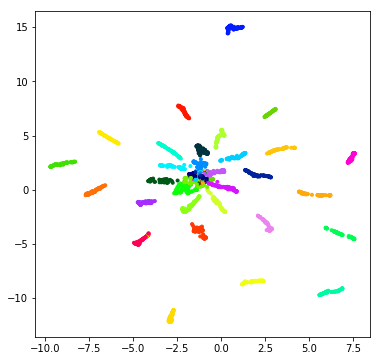

In [21]:
# plot results here
%matplotlib inline
cmap = cm.get_cmap('gist_ncar')
cmap = cmap(np.linspace(0,0.9,32))
cmap = cmap[np.random.permutation(32),:]
plt.figure(figsize=(6,6))
# each point is colored based on stimulus identity
plt.scatter(out[:,0],out[:,1],color=cmap[istim,:],marker='.')
plt.show()

In [22]:
# classify results
import sklearn.neighbors

# classifier
n_neighbors = 1
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
# fit classifier using half of the data
# low-dimensional data
svc = clf.fit(out[::2,:],istim[::2])
# predict stimuli from other half
istim_pred = clf.predict(out[1::2,:])
accuracy   = (istim_pred==istim[1::2]).mean()
print(accuracy)

# also, train classifier with more dimensions (all data)
# does dimensionality reduction help classification?

# try other classifiers like an SVM

0.9590395480225988
